# Similar Product Search

## Packages

In [5]:
!pip install fastai -Uqq

In [6]:
from fastai.vision.all import *
from torch.optim import AdamW
from tqdm import tqdm

## Download dataset

In [7]:
import os
os.environ['KAGGLE_USERNAME'] = "lkarjun"
os.environ['KAGGLE_KEY'] = "96d0e367426087ce8a91876ea3de5244"

In [ ]:
!kaggle datasets download -d kritanjalijain/outfititems
!unzip outfititems.zip

In [8]:
dataset_path = Path("/content/val/val")

## Here we go

### Dataloader

In [9]:
def get_fnames(dataset_path, folders: list, n_files = 300):
  fnames = []
  full_fnames = []
  for folder in folders:
    for sub_folder in (dataset_path/folder).iterdir():
      files = get_image_files(dataset_path/sub_folder)
      full_fnames += files
      fnames += files[:n_files]
  return fnames, full_fnames

In [10]:
fnames, full_fnames = get_fnames(dataset_path, ['bottomwear', 'one-piece', 'footwear', 'upperwear', 'accessories'])

In [11]:
BATCH_SIZE = 120
RESIZE = 224

def get_dls(fnames):
  dls = ImageDataLoaders.from_path_func(
                dataset_path, 
                fnames, 
                parent_label,
                batch_tfms = Normalize.from_stats(*imagenet_stats), 
                item_tfms = Resize(RESIZE), 
                bs=BATCH_SIZE
              )
  return dls

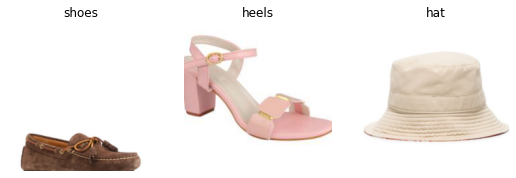

In [12]:
dls = get_dls(fnames)

dls.show_batch(max_n = 3)

In [13]:
dls.vocab

['bag', 'dress', 'flats', 'hat', 'heels', 'jacket', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 'sneakers', 'tshirt']

In [14]:
x, y = dls.one_batch()
x.shape, y.shape, dls.c

(torch.Size([120, 3, 224, 224]), torch.Size([120]), 13)

### Model

In [15]:
body = create_body(resnet50, cut=-2)

In [16]:
head = create_head(nf = num_features_model(body), 
                   lin_ftrs=[2048, 512, 256, 128],
                   n_out = dls.c, 
                   concat_pool=False, 
                   pool=True)

In [17]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [18]:
model = RImgModel(body, head).cuda()

In [19]:
def model_splitter(model):
    return L(model.body, model.head).map(params)

In [20]:
learn = Learner(dls, model,
                splitter = model_splitter, 
                metrics=[accuracy, error_rate])

In [21]:
learn.summary()

RImgModel (Input shape: 120 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     120 x 64 x 112 x 11 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     120 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     120 x 256 x 56 x 56 
Conv2d                                    16384      True      
BatchNorm2d                        

In [22]:
learn.freeze()

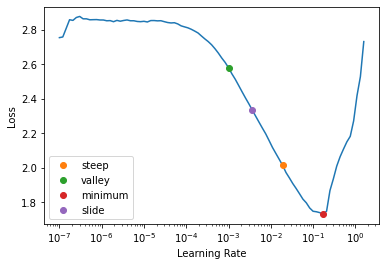

In [24]:
lr_values = learn.lr_find(suggest_funcs=[steep, valley, minimum, slide])

In [25]:
learn.fit_one_cycle(5, lr_values.slide)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.663418,0.566843,0.822819,0.177181,00:43
1,0.948700,0.384541,0.891275,0.108725,00:41
2,0.620571,0.294722,0.912752,0.087248,00:41
3,0.425757,0.233641,0.920805,0.079195,00:41
4,0.302076,0.220154,0.931544,0.068456,00:41


In [26]:
# slice lr: lower lr for body and high for head

learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.124428,0.213172,0.938255,0.061745,00:45
1,0.119843,0.210066,0.935570,0.064429,00:45
2,0.114678,0.209396,0.940940,0.059060,00:45
3,0.106567,0.204843,0.940940,0.059060,00:45


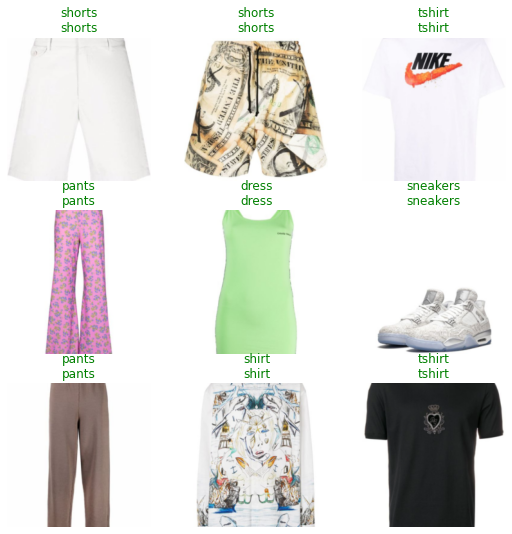

In [29]:
learn.show_results()

In [30]:
intrep = ClassificationInterpretation.from_learner(learn)

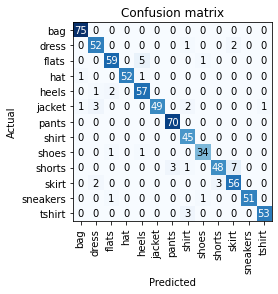

In [31]:
intrep.plot_confusion_matrix()

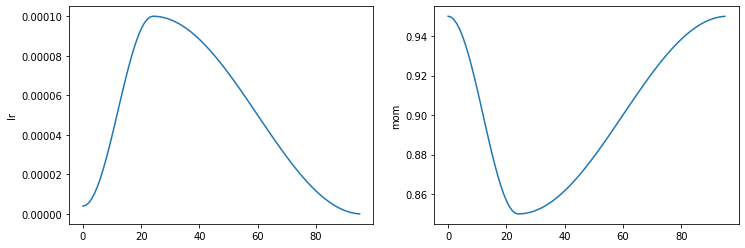

In [32]:
learn.recorder.plot_sched()

### Geting feature vector

In [42]:
learn.model.head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=2054, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(2054, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=2054, out_features=512, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.25, inplace=False)
  (12): Linear(in_features=512, out_features=256, bias=False)
  (13): ReLU(inplace=True)
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.25, inplace=False)
  (16): Linear(in_features=256, out_features=128, bias=False)
  (17): ReLU(inplace=True)
  (18): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine

In [33]:
def get_feature_vector(learn, X = None, dl = None, batch = False):
  with hook_output(learn.model.head[16]) as h:
    if batch:
      y = learn.get_preds(dl=dl)
    else:
      y = learn.predict(X)
  return h.stored

In [36]:
def process_batch(fnames, learn):
  features = []
  dl = learn.dls.test_dl(fnames)
  for i in tqdm(range(0, len(fnames), BATCH_SIZE)):
      names = fnames[i:i + BATCH_SIZE]
      dl = learn.dls.test_dl(names)
      features += get_feature_vector(dl = dl, batch = True, learn = learn)

  features = torch.stack(features, dim = 0).cpu().numpy()
  return features

In [ ]:
features = process_batch(full_fnames, learn)

In [38]:
features.shape

(4784, 128)

### Similar Images

In [39]:
from sklearn.neighbors import NearestNeighbors

def get_neighbor(features):
  neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute',metric='cosine')
  return neighbors.fit(features)

In [40]:
neighbors = get_neighbor(features)

In [41]:
def plot_similar_images(test_idx, features, fnames):
  distances, indices = neighbors.kneighbors([features[test_idx]])
  plt.imshow(Image.open(fnames[test_idx]))
  plt.title("Image")

  fig, axs = plt.subplots(2,5, figsize=(15, 10))

  for ax, idx, dis in zip(axs.flatten(), indices.flatten(), distances.flatten()):
    img = Image.open(fnames[idx])
    ax.imshow(img)
    ax.set_title(dis)

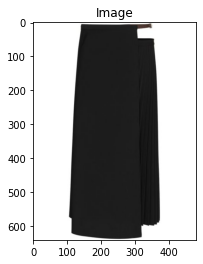

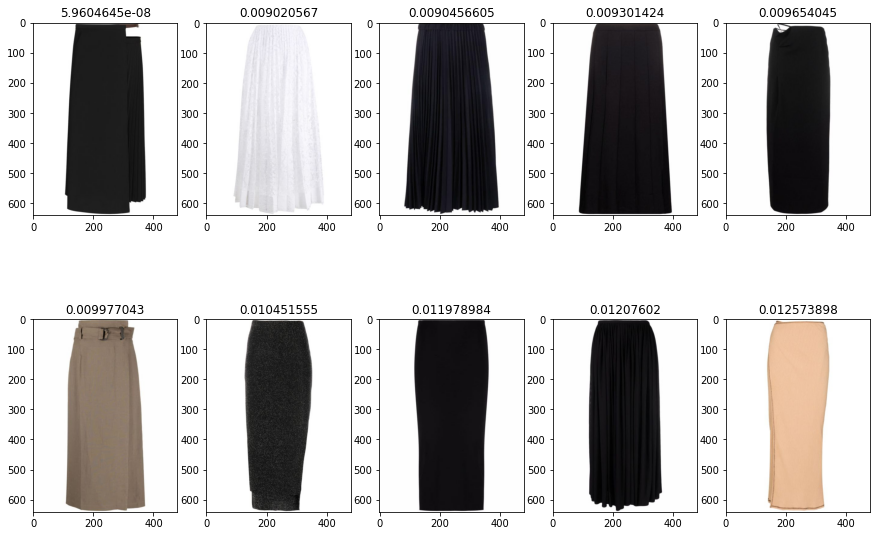

In [43]:
plot_similar_images(344, features, full_fnames)

### Save Objs

In [45]:
pickle.dump(neighbors, open('new_neighbor.pkl', 'wb'))

In [46]:
pickle.dump(features, open('features.pkl', 'wb'))

In [47]:
pickle.dump(full_fnames, open('file_names.pkl', 'wb'))